In [1]:
import pyads
from ctypes import sizeof
from astropy.time import Time
from astropy.timeseries import TimeSeries
from astropy.coordinates import EarthLocation, Longitude, SkyCoord, get_sun, AltAz
from astropy import units as u
import datetime
from time import sleep
import matplotlib.pyplot as plt
import numpy as np

In [2]:
'''
ADSSTATES:
{
    Invalid = 0,
    Idle = 1,
    Reset = 2,
    Init = 3,
    Start = 4,
    Run = 5,
    Stop = 6,
    SaveConfig = 7,
    LoadConfig = 8,
    PowerFailure = 9,
    PowerGood = 10,
    Error = 11,
    Shutdown = 12,
    Suspend = 13,
    Resume = 14,
    Config = 15,
    Reconfig = 16,
    Maxstates = 17,
}
'''

'\nADSSTATES:\n{\n    Invalid = 0,\n    Idle = 1,\n    Reset = 2,\n    Init = 3,\n    Start = 4,\n    Run = 5,\n    Stop = 6,\n    SaveConfig = 7,\n    LoadConfig = 8,\n    PowerFailure = 9,\n    PowerGood = 10,\n    Error = 11,\n    Shutdown = 12,\n    Suspend = 13,\n    Resume = 14,\n    Config = 15,\n    Reconfig = 16,\n    Maxstates = 17,\n}\n'

In [62]:
# for simple connection follow instructions of:
# http://soup01.com/en/2022/06/02/beckhoffusing-python-to-communicate-with-twincat-by-ads/

ads_net_id = '134.76.204.249.1.1' # net_id of PLC -> look at SYSTEM/Tasks/Routes
plc = pyads.Connection(ads_net_id, pyads.PORT_TC3PLC1) # create plc object with net_id and port 851
'''
print("Connecting to TwinCAT PLC..")
plc.open() # open plc connection
print("Current connection status:",plc.is_open)
print("Current Status:",plc.read_state())

print("Closing the Connections..")
plc.close()
print("Current Status:",plc.is_open)
'''
def test_JD2LST(time = datetime.datetime.now(), loc = [51.55931126132681, 9.945392608768366, 200]) -> np.array([]):
    # all values with _astro are computed using astropy
    # _beck are values from beckhoff
    # loc [lat deg,lon deg, height m], standart is IAG telescope
    
    # JD time
    timeJD_astro = Time(time).jd
    loc_astro = EarthLocation(lat=loc[0]*u.deg, lon=loc[1]*u.deg, height=loc[2]*u.m).geodetic
    #LST time
    LST_astro =  Time(timeJD_astro, format='jd', location=loc_astro).sidereal_time('apparent')


    #------------------------------------------------------------------------------------------
    plc.open() # open plc connection

    # get relevant symbols _b for beckhoff
    loc0_b = plc.get_symbol('MAIN.loc0', structure_def=(("longitude", pyads.PLCTYPE_LREAL,1),("latitude", pyads.PLCTYPE_LREAL,1),("height", pyads.PLCTYPE_LREAL,1)))
    jd1_b = plc.get_symbol('MAIN.jd1')
    lst1_b = plc.get_symbol('MAIN.lst1')

    # write values to symbols
    loc0_b.write({'longitude':loc[1], 'latitude':loc[0], 'height':loc[2]})
    jd1_b.write(timeJD_astro)
    # change estate to execute test -> 5 == test_state.JD2LST
    plc.write_by_name(data_name='MAIN.estate', value=5,plc_datatype=pyads.PLCTYPE_INT)
    sleep(0.05) # new cyle of twincat
    # get LST value
    LST_beck =  lst1_b.read()
    plc.close()
    #------------------------------------------------------------------------------------------
    return np.array([LST_astro.degree, LST_beck, LST_astro.degree-LST_beck])

def test_EQ2HOR(coord_eq, time = datetime.datetime.now(), loc = [51.55931126132681, 9.945392608768366, 200]) -> np.array([]):
    # all values with _astro are computed using astropy
    # _beck are values from beckhoff
    # loc [lat deg,lon deg, height m], standart is IAG telescope
    
    # JD time
    timeJD_astro = Time(time).jd
    
    # obs location
    loc_astro = EarthLocation(lat=loc[0]*u.deg, lon=loc[1]*u.deg, height=loc[2]*u.m)
    LST_astro =  Time(timeJD_astro, format='jd', location=loc_astro).sidereal_time('apparent')
    # Astropy coord-trafo
    coord_eq_astro = SkyCoord(ra=coord_eq[0]*u.degree, dec=coord_eq[1]*u.degree, frame="fk5")
    
    altaz_frame = AltAz(location=loc_astro, obstime=Time(time))
    coord_hor_astro = coord_eq_astro.transform_to(altaz_frame)
    
    #------------------------------------------------------------------------------------------
    plc.open() # open plc connection

    # get relevant symbols _b for beckhoff
    coord_in_b = plc.get_symbol('MAIN.in_coord_eq', structure_def=(("ra", pyads.PLCTYPE_LREAL,1),("dec", pyads.PLCTYPE_LREAL,1)))
    loc0_b = plc.get_symbol('MAIN.loc0', structure_def=(("longitude", pyads.PLCTYPE_LREAL,1),("latitude", pyads.PLCTYPE_LREAL,1),("height", pyads.PLCTYPE_LREAL,1)))
    jd1_b = plc.get_symbol('MAIN.jd1')
    alt_b = plc.get_symbol('MAIN.alt')
    az_b = plc.get_symbol('MAIN.az')
    coord_out_b = plc.get_symbol('MAIN.out_coord_hor', structure_def=(("alt", pyads.PLCTYPE_LREAL,1),("az", pyads.PLCTYPE_LREAL,1)))
    # write values to symbols
    loc0_b.write({'longitude':loc[1], 'latitude':loc[0], 'height':loc[2]})
    jd1_b.write(timeJD_astro)
    coord_in_b.write({'ra':coord_eq[0], 'dec':coord_eq[1]})
    # change estate to execute test -> 2 == test_state.EQ2HOR
    plc.write_by_name(data_name='MAIN.estate', value=2, plc_datatype=pyads.PLCTYPE_INT)
    sleep(0.05) # new cyle of twincat
    
    # get ALT/AZ values
    # STELLA code
    alt_beck =  alt_b.read()
    az_beck = az_b.read()
    # simple code
    coord_out_beck = coord_out_b.read()
    plc.close()
    #------------------------------------------------------------------------------------------
    
    return np.array([[alt_beck, az_beck],[coord_out_beck['alt'], coord_out_beck['az']],[coord_hor_astro.alt.degree, coord_hor_astro.az.degree]])
    



Starting test!
Testing...
Finished!


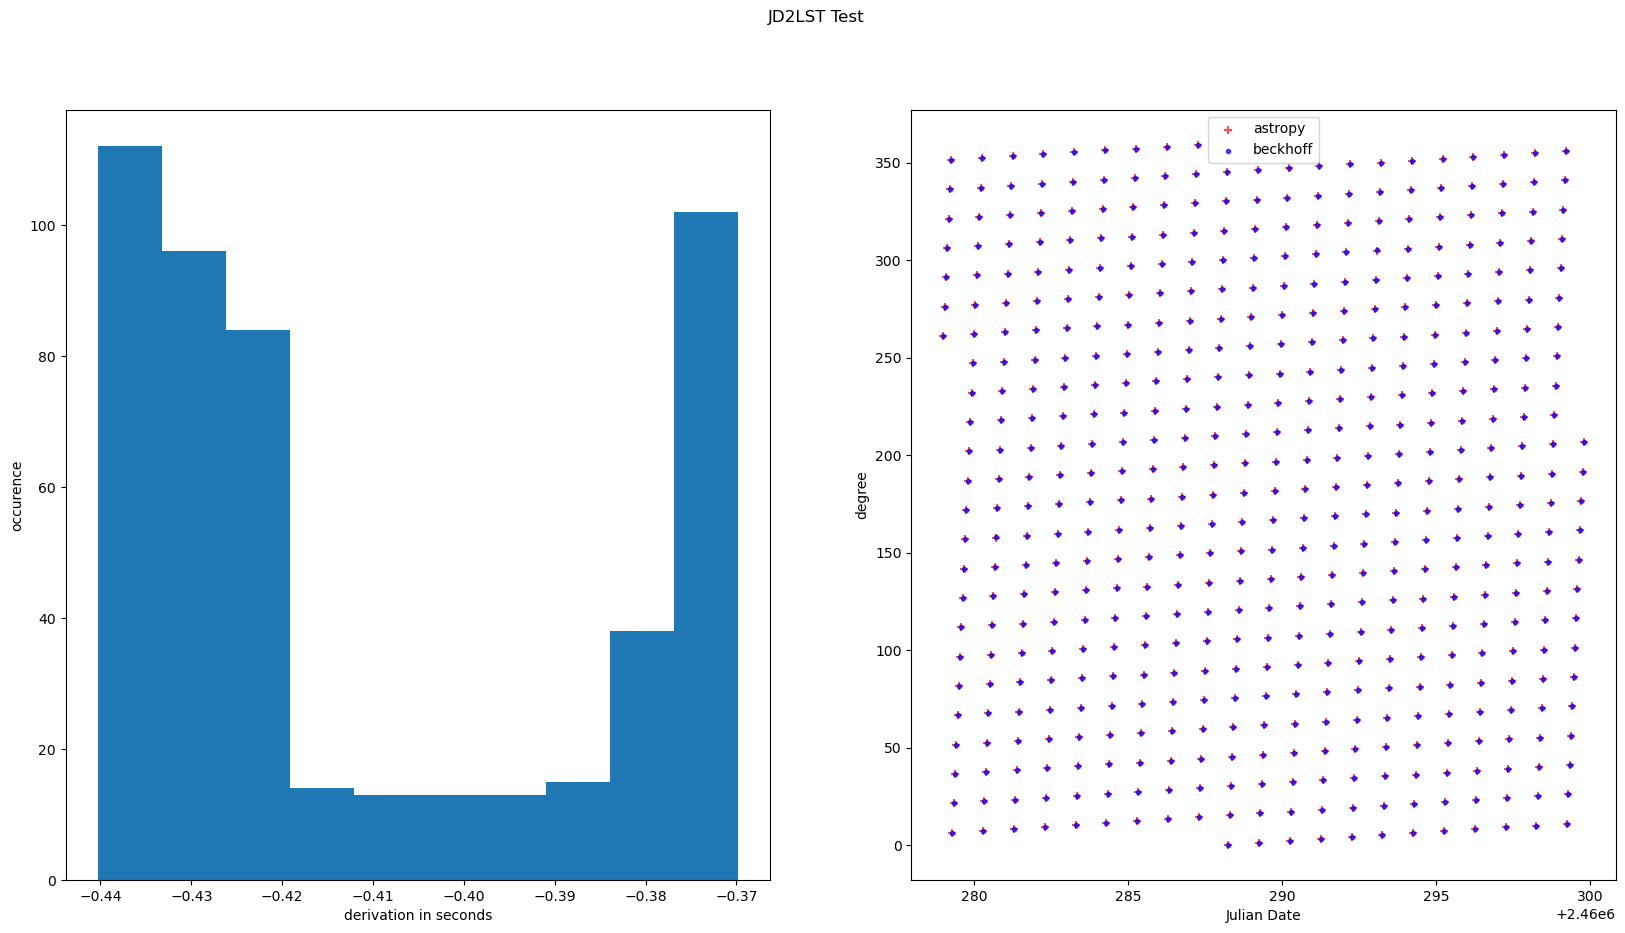

In [59]:
# test JD2LST
print('Starting test!')
now =  datetime.datetime.now()
# make time series
ts = TimeSeries(time_start=now,
                 time_delta=60 * u.min,
                 n_samples=500)
print('Testing...')
results = np.array([test_JD2LST(time) for time in ts.time])
print('Finished!')


fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('JD2LST Test')
axs[0].hist(results[:,2]*3600/15)
axs[0].set_xlabel('derivation in seconds')
axs[0].set_ylabel('occurence')

axs[1].scatter(ts.time.jd, results[:,0], marker='+', alpha=0.7, c='red', label='astropy')
axs[1].scatter(ts.time.jd, results[:,1], marker='.', alpha=0.7, c= 'blue', label='beckhoff')
axs[1].set_xlabel('Julian Date')
axs[1].set_ylabel('degree')
axs[1].legend()
plt.show()

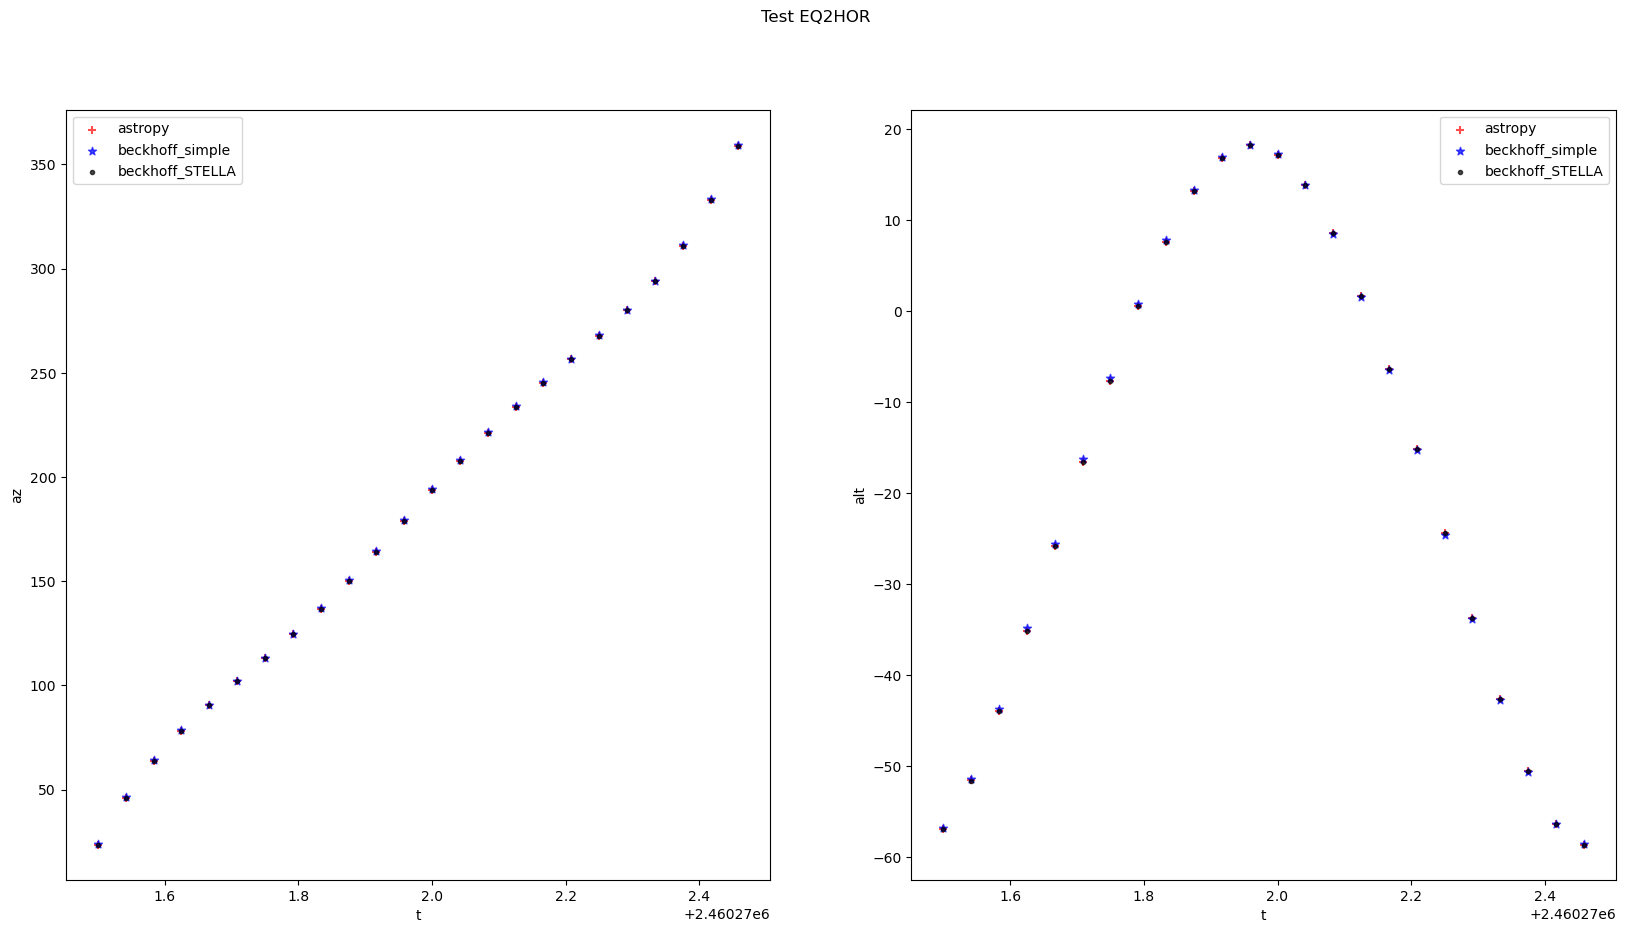

In [60]:
#Horizons sun position
time = datetime.datetime(2023, 11, 23, 0, 0, 0)
coord_sun = np.array([237.91670, -20.16854])
ts = TimeSeries(time_start=time,
                 time_delta=60 * u.min,
                 n_samples=24)
# Hoizons Alt Az for the following location: Alt:-56.970989, Az:23.511494
results=np.array([test_EQ2HOR(coord_sun, t,[51.55931126132681, 9.945392608768366, 200]) for t in ts.time ])
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Test EQ2HOR')
axs[0].scatter(ts.time.jd, results[:,2,1], marker='+', alpha=0.7, c='red', label='astropy')
axs[0].scatter(ts.time.jd, results[:,1,1], marker='*', alpha=0.7, c='blue', label='beckhoff_simple')
axs[0].scatter(ts.time.jd, results[:,0,1], marker='.', alpha=0.7, c='black', label='beckhoff_STELLA')
axs[0].set_xlabel('t')
axs[0].set_ylabel('az')
axs[0].legend()

axs[1].scatter(ts.time.jd, results[:,2,0], marker='+', alpha=0.7, c='red', label='astropy')
axs[1].scatter(ts.time.jd, results[:,1,0], marker='*', alpha=0.7, c='blue', label='beckhoff_simple')
axs[1].scatter(ts.time.jd, results[:,0,0], marker='.', alpha=0.7, c='black', label='beckhoff_STELLA')
axs[1].set_xlabel('t')
axs[1].set_ylabel('alt')
axs[1].legend()
plt.show()

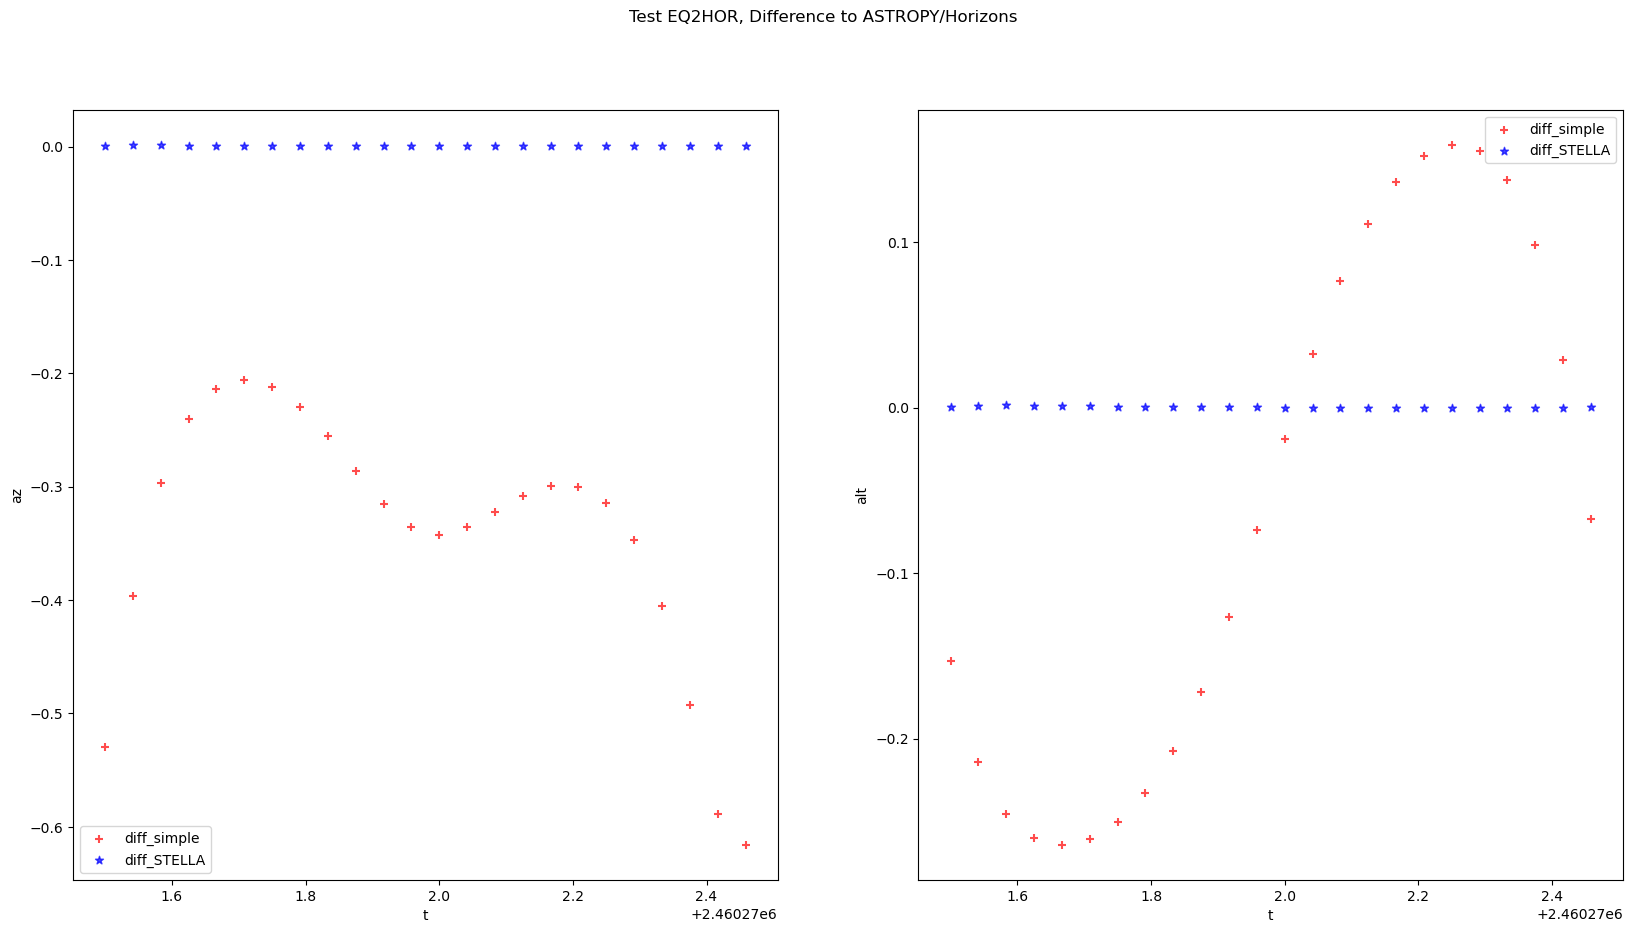

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Test EQ2HOR, Difference to ASTROPY/Horizons')
axs[0].scatter(ts.time.jd, results[:,2,1]- results[:,1,1], marker='+', alpha=0.7, c='red', label='diff_simple')
axs[0].scatter(ts.time.jd, results[:,2,1]- results[:,0,1], marker='*', alpha=0.7, c='blue', label='diff_STELLA')
axs[0].set_xlabel('t')
axs[0].set_ylabel('az')
axs[0].legend()

axs[1].scatter(ts.time.jd, results[:,2,0]-results[:,1,0], marker='+', alpha=0.7, c='red', label='diff_simple')
axs[1].scatter(ts.time.jd, results[:,2,0]-results[:,0,0], marker='*', alpha=0.7, c='blue', label='diff_STELLA')
axs[1].set_xlabel('t')
axs[1].set_ylabel('alt')
axs[1].legend()
plt.show()